In [1]:
import os

# Specify the bin folder path of OpenSim installation
# (Use 'r' prefix to avoid backslash errors)
opensim_bin_path = r'C:\OpenSim 4.5\bin'

try:
    os.add_dll_directory(opensim_bin_path)
except AttributeError:
    # For Python versions below 3.8 (for compatibility)
    os.environ['PATH'] = opensim_bin_path + ';' + os.environ['PATH']

import opensim as osim

# Test
print(f"OpenSim Version: {osim.__version__}")

OpenSim Version: 4.5


# Rajagopal2016 vs RajagopalLaiUhlrich2023 Model Comparison

## Basic Information

### Rajagopal2016.osim
- **Based on**: Original model from Rajagopal et al. (2016) paper
- **Modifications**:
  - Updated to OpenSim 4.5 XML format
  - Set `fiber_damping` to 0.1 for all muscles (Millard et al. 2013 recommendation)

### RajagopalLaiUhlrich2023.osim
- **Based on**: Rajagopal2016 model with additional modifications
- **Modifications**:
  1. **Lai et al. (2017) modifications**:
     - Improvements for high hip and knee flexion simulations
     - Increased knee flexion range
     - Updated knee muscle paths
     - Modified force-generating properties of 11 muscles
  
  2. **Uhlrich et al. (2022) modifications**:
     - Calibrated passive muscle force curves to match experimental data from Silder et al. (2007)
     - Updated hip abductor muscle paths to more closely align with MRI and experimental data

## Key Differences Summary

| Item | Rajagopal2016 | RajagopalLaiUhlrich2023 |
|------|---------------|-------------------------|
| **Number of muscles** | 160 | 160 |
| **Muscle type** | Millard2012EquilibriumMuscle | Millard2012EquilibriumMuscle |
| **High flexion support** | Limited | Improved (Lai et al.) |
| **Passive force curve** | Default | Experimental data-based calibration (Uhlrich et al.) |
| **Hip abductor path** | Default | MRI/experimental data-based (Uhlrich et al.) |
| **11 muscle properties** | Default | Modified (Lai et al.) |

## When to Use

### Recommended for Rajagopal2016:
- General gait simulations
- When you want to use the original model characteristics as-is
- Standard analysis tasks

### Recommended for RajagopalLaiUhlrich2023:
- Simulations involving high hip/knee flexion (e.g., stair climbing, deep squatting)
- When more accurate passive muscle force is needed
- When a model reflecting latest research results is needed
- Knee contact force analysis (Uhlrich et al. research purpose)

## Accuracy Comparison

### General Answer: **RajagopalLaiUhlrich2023 is more accurate**

**Reasons:**
1. **Experimental data-based calibration**: Passive muscle force curves are calibrated to match experimental data from Silder et al. (2007)
2. **MRI-based muscle paths**: Hip abductor paths are updated to more closely align with MRI and experimental data
3. **High flexion motion validation**: Lai et al. (2017) addressed and validated issues with high flexion motions
4. **Latest research reflection**: More recent model reflecting research results up to 2022

### However, it depends on the purpose:

#### Rajagopal2016 is more suitable when:
- **Original paper reproduction**: When reproducing results from Rajagopal et al. (2016) paper
- **Standard benchmark**: When a standard model is needed for comparison with other studies
- **Simple gait analysis**: Both models are sufficiently accurate for general gait simulations

#### RajagopalLaiUhlrich2023 is more accurate when:
- **High flexion motions** (knee flexion > 90°, hip flexion > 90°)
- **Analysis where passive muscle force is important** (e.g., passive joint moment analysis)
- **Knee contact force analysis**
- **Analysis aligned with latest research standards**

### Conclusion:
In most cases, **RajagopalLaiUhlrich2023** is recommended, especially:
- Higher agreement with experimental data
- More accurate over a wider range of motions
- Reflects latest research results

However, **Rajagopal2016** should be used when reproducing specific paper results or when standard benchmarks are needed.

## References

- **Rajagopal et al. (2016)**: Full-body musculoskeletal model for muscle-driven simulation of human gait
- **Lai et al. (2017)**: Why are antagonist muscles co-activated in my simulation?
- **Uhlrich et al. (2022)**: Muscle coordination retraining inspired by musculoskeletal simulations reduces knee contact force
- **Silder et al. (2007)**: Identification of passive elastic joint moment-angle relationships in the lower extremity


Analyzing muscle: soleus_r
Muscle type: Millard2012EquilibriumMuscle
Curves loaded successfully!


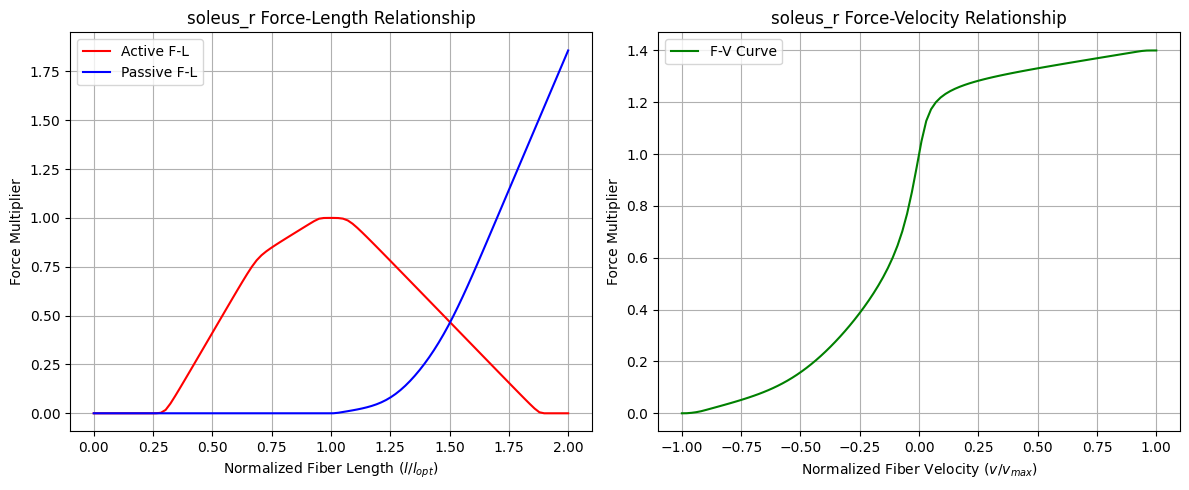

In [2]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt

# 1. Load model - Rajagopal2016 model
model_path = 'opensim_models/Rajagopal/Rajagopal2016.osim'
model = osim.Model(model_path)
model.initSystem()

# 2. Select muscle to analyze - In Rajagopal2016, use 'bflh_r' (biceps femoris long head)
# All muscles in Rajagopal2016 model are Millard2012EquilibriumMuscle type.
muscle_name = 'soleus_r'
base_muscle = model.getMuscles().get(muscle_name)
muscle = osim.Millard2012EquilibriumMuscle.safeDownCast(base_muscle)

if not muscle:
    print(f"Error: Muscle '{muscle_name}' not found or is not Millard2012EquilibriumMuscle type.")
    print(f"Muscle type: {base_muscle.getConcreteClassName() if base_muscle else 'Not found'}")
    exit()

print(f"Analyzing muscle: {muscle_name}")
print(f"Muscle type: {muscle.getConcreteClassName()}")

# 3. Get Curve objects
# For Millard2012EquilibriumMuscle, use getFiberForceLengthCurve() for passive (force-length) curve.
active_fl_curve = muscle.getActiveForceLengthCurve()
fiber_fl_curve = muscle.getFiberForceLengthCurve()
fv_curve = muscle.getForceVelocityCurve()

print("Curves loaded successfully!")

# --- Data Extraction ---

# 4. Generate Force-Length Relationship data
norm_lengths = np.linspace(0.0, 2.0, 100)
active_forces = []
passive_forces = []

for l in norm_lengths:
    # Use calcValue() method to return multiplier at the given length
    active_forces.append(active_fl_curve.calcValue(l))
    # Calculate passive force through FiberForceLengthCurve
    passive_forces.append(fiber_fl_curve.calcValue(l))

# 5. Generate Force-Velocity Relationship data
norm_velocities = np.linspace(-1.0, 1.0, 100)
velocity_forces = []

for v in norm_velocities:
    velocity_forces.append(fv_curve.calcValue(v))

# --- Visualization (Matplotlib) ---

plt.figure(figsize=(12, 5))

# Plot 1: Force-Length
plt.subplot(1, 2, 1)
plt.plot(norm_lengths, active_forces, label='Active F-L', color='red')
plt.plot(norm_lengths, passive_forces, label='Passive F-L', color='blue')
plt.title(f'{muscle_name} Force-Length Relationship')
plt.xlabel('Normalized Fiber Length ($l / l_{{opt}}$)')
plt.ylabel('Force Multiplier')
plt.grid(True)
plt.legend()

# Plot 2: Force-Velocity
plt.subplot(1, 2, 2)
plt.plot(norm_velocities, velocity_forces, label='F-V Curve', color='green')
plt.title(f'{muscle_name} Force-Velocity Relationship')
plt.xlabel('Normalized Fiber Velocity ($v / v_{{max}}$)')
plt.ylabel('Force Multiplier')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()